# DSAN5650 Homework 4: "Cross-Prediction" of Attitudes and Behaviors

In [ ]:
# import corrections
# corrections.fetch("HW4")

# [Part 2] Modeling *Behaviors* with Experimental Audit Data

In this part, we'll start to see the issue with conflating attitudes and behavior (so, in other words, the dangers that can arise from assuming that **survey responses** can be used as a "mirror" for real-world **behavior**), which will motivate the move in Part 3 below to *merge* the survey and experimental-audit data and analyze this discrepancy itself.

But, don't worry! This part won't involve another 7 tedious steps of doing the same thing you did in Part 1! Instead, we'll use it as an opportunity to explore a package called [**Bambi**](https://bambinos.github.io/bambi/), which is essentially a wrapper around more in-the-weeds Bayesian model-building tools like PyMC.

> *The **social contract** here, though, is that you promise to **keep your Bayesian modeling skills sharp**, the skills you've built in HW2 and in Part 1 above!*
>
> *I say that here because, using Bambi essentially takes us *away from* the PyMC modeling approach---the **"learning a modeling *language*"** approach---and back towards just choosing from a collection of pre-made, "off-the-shelf" algorithms: the approach of using `lm()` or `statsmodels` for example.*

So yeah, in general I want you to avoid seeing `lm()` or `statsmodels` as "default" approaches, and instead see them as tools you can take advantage of **after** you've gone through the modeling steps and determined that the assumptions underlying e.g. logistic regression are appropriate for your scenario. *But*, since you just trooped through the non-off-the-shelf "hard mode" approach in Part 1, and "arrived at" the use of logistic regression in Part 1.5, in this part we'll basically just skip those hard parts and ask Bambi to run a Bayesian logistic regression for us (with PyMC still running "under the hood"!)

Since this part is similar to Part 1---it's the same analysis, just using the **experimental audit** data with the `dohire` variable rather than the survey data with the `sayhire` dependent variable---there will be less wordy instructions here. So, if you get stuck, you can look back at the equivalent portion of Part 1 for more details!

**Python Imports**

In [2]:
#%run jupyter_fixes.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patchworklib as pw

import pymc as pm
import arviz as az

<Figure size 100x100 with 0 Axes>

**Loading the Data**

The following code cell loads the **experimental-audit-level** dataset, `pager_matched_experiments.csv`, where the auditor in each row is uniquely identified by `audit_id`. For each auditor, we have the following information:

* `firm_id`: The firm (from the previous dataset) whose application process the auditor went through
* `con`: Has the value `0` if the auditor did **not** list/mention a prior criminal conviction in their application, and `1` if the auditor **did** list such a prior conviction
* `race_str`: A string variable which is `"White"` for the recruited self-reported white auditors and `"Black"` for the recruited self-reported black auditors
* `race` Same as `race_str`, but with **`"White"`** mapped to the int value **`0`** and **`"Black"`** mapped to the int value **`1`**
* `sayhire`: Has the value **`1`** if the firm said they would "likely" hire an applicant (Chad from the survey vignettes) with the same race and conviction-status as the auditor
* `dohire`: Has the value **`1`** if the auditor ended up getting a callback from the firm, and **`0`** otherwise

In [5]:
exp_df = pd.read_csv("./data/pager_matched_experiments.csv")
exp_df.head()

,audit_id,firm_id,con,race,race_str,sayhire,dohire
0,0,0,0,0,White,1,0
1,1,0,1,0,White,0,1
2,2,0,0,1,Black,1,0
3,3,0,1,1,Black,0,0
4,4,1,0,0,White,1,1


**Computing and Visualizing Summary Statistics**

To see how the dynamics of **behavior** in this part are drastically different from the dynamics of **attitudes** you estimated in Part 1, the following code cells generate numeric and visual summaries of the experimental audit results (the plot here is the same as the plot from the beginning of HW3A).

First, as a nice built-in Pandas function you can use to quickly generate summary statistics, the following cell uses `pd.crosstab()` with the additional `values=` and `aggfunc=` arguments to generate a **two-way cross-tabulation** of the `dohire` rates by race (since `dohire` is a `0`/`1` binary variable, computing the `mean` of this column gives us the proportion of rows containing `1`):

In [6]:
pd.crosstab(exp_df['race_str'], exp_df['con'], values=exp_df['dohire'], aggfunc='mean')

con,0,1
race_str,,
Black,0.139535,0.046512
White,0.325581,0.162791


As you may already know if you've taken DSAN5200 for example, the `seaborn` library works better with "long" data than with the 2x2 structure produced by `pd.crosstab()`. So,  to plot this information more easily, the following code cell generates a 4-row dataset of rates, one row per possible `race_str` x `con` combination:

In [7]:
exp_rate_df = exp_df.groupby(['race_str','con'])['dohire'].mean().to_frame().reset_index()
exp_rate_df.rename(columns={'dohire': 'dohire_rate'}, inplace=True)
exp_rate_df

,race_str,con,dohire_rate
0,Black,0,0.139535
1,Black,1,0.046512
2,White,0,0.325581
3,White,1,0.162791


Which we can now just plug into Seaborn to produce the plot you saw at the beginning of HW3A!

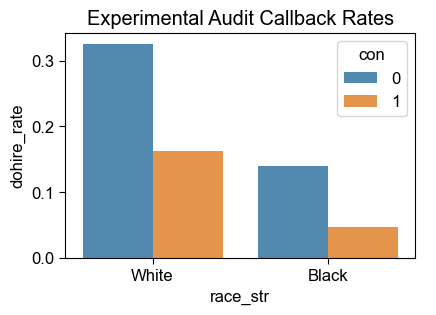

In [8]:
ax = pw.Brick(figsize=(3.5, 2.25));
sns.barplot(
    x="race_str", y='dohire_rate', hue='con', data=exp_rate_df,
    alpha=0.85, order=['White','Black'], ax=ax
);
ax.set_title("Experimental Audit Callback Rates")
ax.savefig()

**The Train-Test Split We'll Use Throughout HW3B**

The following code cell uses `scikit-learn`'s `train_test_split()` function, as in HW3A, with `random_state=5650` included to ensure comparability of your implementations with our solutions!

In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(exp_df, test_size=0.2, random_state=5650)
train_df.shape, test_df.shape

((137, 7), (35, 7))

And finally, we'll create an `OrderedDict` object like we did in HW3A, for collecting the test AUC values which we'll compare at the end

In [10]:
from collections import OrderedDict
exp_model_aucs = OrderedDict()

## [Part 2.0] Baseline Model: Intercept Only

As your first Bambi model (and as the first model you should construct in pretty much **any** ML setting!), let's construct the **baseline model** the same way we did in HW3: a model that just "learns" the overall mean of `dohire`, and always guesses that mean value as the probability of being hired, regardless of the applicant's characteristics.

**Writing the Model in R's Formula Notation**

The weird-ish way to do this with Bambi becomes less weird if you keep in mind how **R's formula syntax** (which is also used by Bambi) works. If you ask `glm()` in R to estimate a logistic regression model using a formula like:

``` {.r}
glm("y ~ x1 + x2 + x3", data = my_df, family = "binomial")
```

R will interpret this as you asking it to estimate the $\beta$ coefficients of the following regression model:

$$
\log\left[ \frac{\Pr(Y = 1)}{1 - \Pr(Y = 1)} \right] = \beta_0 \cdot 1 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3
$$

Where $\beta_0$ is just multiplied by 1 since we want R to estimate this as the **intercept** for the model.

So, if we want a model that **just** learns a single parameter, and uses that parameter value to generate the same guess for every observation regardless of characteristics... we want the above formula but without the `x1`, `x2`, and `x3` terms!

That's super close to the answer, but, R doesn't actually accept a formula like `"y ~ "`, with nothing on the right-hand side, as valid syntax. So what do we do? We look at the above formula, and notice how the intercept we want to estimate is the **coefficient that is just multiplied by 1**. And, the missing piece in `"y ~ "` that would make it valid syntax is exactly this `1`. So, to modify the above R code to only estimate an intercept, we'd change it to:

``` {.r}
glm("y ~ 1", data = my_df, family = "binomial")
```

So, run the code cells in this section the see estimation with Bambi in action (you'll implement your own Bambi models starting in Part 2.3), and notice how:

* (a) Bambi uses the **same formula syntax as R**, but
* (b) Bambi uses `family="bernoulli"` in place of R's `family="binomial"`.

In [ ]:
#!pip install bambi

  Obtaining dependency information for bambi from https://files.pythonhosted.org/packages/09/21/edbfb8d8bf67b5695989c50b5b3d73aaed57b2ac6590a2ba867e06af5b70/bambi-0.15.0-py3-none-any.whl.metadata
  Obtaining dependency information for formulae>=0.5.3 from https://files.pythonhosted.org/packages/88/12/808e8b17e09b60a31ab324d638e50f8cdc11dfcdafb4874a43afad296a2e/formulae-0.5.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 7.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [14]:
import bambi as bmb
nofeats_model = bmb.Model('dohire ~ 1', data=train_df, family='bernoulli')

In [15]:
nofeats_model

       Formula: dohire ~ 1
        Family: bernoulli
          Link: p = logit
  Observations: 137
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.5)

Everything from this point onwards will start to feel more like PyMC! Which makes sense since Bambi is mainly intended as a "wrapper" around estimation libraries like PyMC which eases the pain of having to manually choose prior distributions.

For example, the following two steps serve as Bambi's equivalent to PyMC's `pm.model_to_graphviz()`:

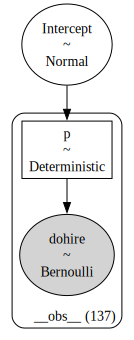

In [16]:
# This step doesn't really have an equivalent in PyMC, since, it's Bambi's
# signal to *pair* the variables you specified in the previous code cell with
# appropriate *prior* distributions:
nofeats_model.build()

# Once the model has been built, however, the following becomes Bambi's direct
# equivalent of PyMC's pm.model_to_graphviz():
nofeats_model.graph()

**Posterior Estimation**

The next cell produces the same **result** as the posterior-estimation step in PyMC (the step where you call `pm.Sample()`). But, notice how:

* (a) We use `.fit()` rather than `.sample()` (since Bambi also "shifts" the syntax more towards `scikit-learn`'s `fit()`-`transform()` setup), and
* (b) We no longer need to use PyMC's indented `with my_model:` syntax!

In [17]:
nofeats_idata = nofeats_model.fit(random_seed=5650)

Modeling the probability that dohire==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


If the call to `fit()` ran successfully (which it should!), `nofeats_idata` will now have a `.posterior` attribute you can use to access the $N = 4000$ samples of `Intercept` values from the posterior distribution:

In [18]:
nofeats_idata.posterior['Intercept']

<xarray.DataArray 'Intercept' (chain: 4, draw: 1000)> Size: 32kB
array([[-1.54607342, -1.56390364, -1.68457807, ..., -1.54785491,
        -1.76513231, -1.50070509],
       [-1.98119994, -1.72071388, -1.66452453, ..., -1.70007862,
        -1.20485368, -1.16205143],
       [-1.63293449, -1.65359801, -1.65359801, ..., -1.66968156,
        -1.23893792, -1.97789765],
       [-1.47921251, -1.75369822, -1.74399225, ..., -1.97136681,
        -1.91677527, -1.91677527]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

And, like you've done with PyMC before, if we want a **point estimate** for the Intercept we can use `.mean(dim=['chain','draw'])` to compute the average value of this parameter over all $N = 4000$ samples:

In [19]:
intercept_mean = float(nofeats_idata.posterior['Intercept'].mean(dim=['chain','draw']))
intercept_mean

-1.6813389639605525

Keep in mind once again that this coefficient value **isn't a probability on its own**, but a "log-odds" value. The model we're estimating here is:

$$
\log\left[ \frac{\Pr(Y = 1)}{1 - \Pr(Y = 1)} \right] = \alpha
$$

Meaning that we need to apply our friend the `expit()` function to transform this point estimate of the intercept into a human-interpretable probability value:

In [20]:
from scipy.special import expit
expit(intercept_mean)

0.1569182493820213

Which is very close to the actual observed **mean** value for `dohire` (the "empirical" $\Pr(Y = 1)$ value), just pulled slightly down towards **0** because of the **prior** that Bambi automatically places on the Intercept coefficient in a logistic regression model:

In [21]:
exp_df['dohire'].mean()

0.1686046511627907

*(If you're interested in what specific priors Bambi is choosing, you can use the following syntax to check. For somewhat weird reasons, it uses a standard-normal $\mathcal{N}(\mu = 0, \sigma = 1)$ prior for all of the $\beta$ coefficients **except for** the intercept, which instead will have a $\mathcal{N}(\mu = 0, \sigma = 1.5)$ prior by default)*

In [22]:
nofeats_model.components['p'].terms

{'Intercept': CommonTerm(  
   name: Intercept,
   prior: Normal(mu: 0.0, sigma: 1.5),
   shape: (137,),
   categorical: False
 )}

**Posterior-Predictive Estimation**

The syntax in Bambi that replaces PyMC's `pm.sample_posterior_predictive()` also takes a step towards mirroring `scikit-learn`, by replacing that function with just `.predict()`

...However, in a setup that I personally find very confusing, calling `.predict()` on its own does not produce **any** visual indication that anything has happened! Things are happening "under the hood", though, don't worry -- to see what `.predict()` does, let's first look at what attributes are stored in `nofeats_idata` right now, *before* we call `.predict()`:

In [23]:
nofeats_idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

You should see that the only **distribution** currently stored is the **posterior** distribution (`sample_stats` just contains information relevant for debugging the Markov Chain Monte Carlo run which produced this distribution, and `observed_data` just "carries along" the `train_df` data we provided to `bmb.Model()` above). This is the distribution that was generated via our call to `.fit()` above.

So, now let's run `.predict()`, where we'll jump right to **predictive performance on the *test* dataset** by including `data=test_df`.

In [24]:
nofeats_model.predict(nofeats_idata, data=test_df, kind='response')

Notice how nothing happened, as expected! However, if it ran without any errors, `nofeats_idata` will now **also** have a `posterior_predictive` attribute:

In [25]:
nofeats_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Which we can now use to compute **mean** values for `dohire` for each test observation, like we did in HW3A:

In [26]:
nofeats_test_dohiremeans = nofeats_idata.posterior_predictive['dohire'].mean(dim=['chain','draw'])
nofeats_test_dohiremeans

<xarray.DataArray 'dohire' (__obs__: 35)> Size: 280B
array([0.154  , 0.17025, 0.15325, 0.16175, 0.1615 , 0.15875, 0.16225,
       0.16775, 0.156  , 0.156  , 0.17275, 0.15875, 0.1545 , 0.15025,
       0.1625 , 0.161  , 0.1535 , 0.16075, 0.15   , 0.15575, 0.15525,
       0.14425, 0.15675, 0.151  , 0.159  , 0.158  , 0.15675, 0.15625,
       0.1515 , 0.15625, 0.164  , 0.16625, 0.15575, 0.15675, 0.1455 ])
Coordinates:
  * __obs__  (__obs__) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34

And we can wrap up the baseline model by plotting the test ROC curve and storing the resulting AUC score in `exp_model_aucs`, for comparison at the end! (Note: this is the exact same `plot_roc()` function from HW3A, which you should use so the autograder can autograde pls)

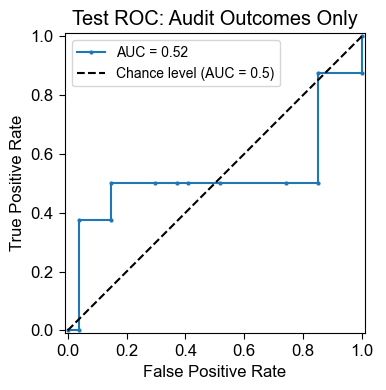

OrderedDict([('nofeats', 0.5231481481481481)])

In [27]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
def plot_roc(true_labels, pred_p_hire, plot_title="ROC Curve"):
    ax = pw.Brick(figsize=(3, 3))
    model_fpr, model_tpr, model_thresholds = roc_curve(
        y_true=true_labels, y_score=pred_p_hire, pos_label=1, drop_intermediate=True
    )
    model_auc = auc(model_fpr, model_tpr)
    roc_display = RocCurveDisplay(fpr=model_fpr, tpr=model_tpr, roc_auc=model_auc)
    roc_display = roc_display.plot(ax=ax, marker="o", markersize=2, plot_chance_level=True)
    ax.set_title(plot_title);
    ax.legend(fontsize=10);
    display(ax.savefig())
    return model_auc

exp_model_aucs['nofeats'] = plot_roc(
    test_df['dohire'], nofeats_test_dohiremeans,
    "Test ROC: Audit Outcomes Only"
)
exp_model_aucs

And thus we see that, by learning only the overall mean `dohire` value, we do only slightly better than random chance. In the next 3 parts, it's your turn to estimate the non-baseline models which actually incorporate the information we have for each auditor!

## [Part 2.1] Model With Just Conviction Status

### [Question 2.1.1] Write and Fit Model with Bambi

In [28]:
train_df

,audit_id,firm_id,con,race,race_str,sayhire,dohire
127,127,31,1,1,Black,0,0
160,160,40,0,0,White,1,0
7,7,1,1,1,Black,1,0
30,30,7,0,1,Black,1,0
1,1,0,1,0,White,0,1
...,...,...,...,...,...,...,...
115,115,28,1,1,Black,0,0
41,41,10,1,0,White,1,0
97,97,24,1,0,White,0,1
162,162,40,0,1,Black,1,0


Use what you learned in Part 2.0 to write a new Bambi model, a logistic regression model like before but this time incorporating the auditor's `con` value as the sole predictor (the model should still have an **intercept**, though!). Store the model object itself as `con_model`.

Then, use the `.fit()` function to estimate the posterior distribution over the two parameters (the `Intercept` and `con` coefficients), storing the result in `con_idata`.

In [29]:
# @title Q2.1.1-response
con_model = bmb.Model('dohire ~ con', data = train_df, family='bernoulli') # Your code here: replace with Bambi model as described above
con_idata = con_model.fit(random_seed=5650) # Your code here: estimate posterior distribution of coefficients

Modeling the probability that dohire==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, con]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
# @title Q2.1.1-public-tests
q2_1_1_public_tests = {
    'con_model defined': '✅ Passed!' if 'con_model' in globals() else "🔲 No variable named 'con_model' exists in Python memory",
    'con_idata defined': '✅ Passed!' if 'con_idata' in globals() else "🔲 No variable named 'con_idata' exists in Python memory",
}
q2_1_1_public_tests

If all went well, you should be able to run the following cell to generate the visual PGM representation of `con_model`:

*(Note that you do **not** have to call `.build()` if you've already run `.fit()`, which you should have done in the previous response cell! `.fit()` automatically calls `.build()` as a first step under the hood)*

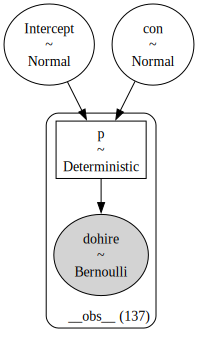

In [32]:
con_model.graph()

And it should look similar to the following:

<center>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/e0a5c5efa29a25fae1959ff09871196d21f20397/2025-sum-dsan5650/hw3/bambi_conmodel.svg" width="30%" />
</center>

### [Question 2.1.2] Extract and Interpret Point Estimates for Coefficients

Next, extract *point* estimates for our two coefficients in the same way that we computed a point estimate for the `Intercept` coefficient in the baseline model.

Then, whereas for that model we computed a **single** probability estimate (our estimate of $\Pr(Y = 1)$, which we derived using `expit()`), here since we have an intercept **and** a coefficient estimate for `con`, you will need to derive and then store **two** probability values:

* (a) Store the estimated value of $\Pr(\texttt{dohire} = 1 \mid \texttt{con} = 0)$ in `pr_dohire_nocon`, and then
* (b) Store the estimated value of $\Pr(\texttt{dohire} = 1 \mid \texttt{con} = 1)$ in `pr_dohire_con`,

as indicated in the comments within the code cell.

In [44]:
con_idata.posterior

<xarray.Dataset> Size: 72kB
Dimensions:    (chain: 4, draw: 1000)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    Intercept  (chain, draw) float64 32kB -1.584 -1.092 -1.617 ... -1.456 -1.401
    con        (chain, draw) float64 32kB 0.032 -1.494 ... -0.8784 -0.5201
Attributes:
    created_at:                  2025-08-08T02:06:34.048821+00:00
    arviz_version:               0.21.0
    inference_library:           pymc
    inference_library_version:   5.23.0
    sampling_time:               0.8128771781921387
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.15.0

In [45]:
# @title Q2.1.2-response

# (Step 1) Extract point estimates for coefficients on 'Intercept' and 'con'

# Your code here
intercept_mean = float(con_idata.posterior['Intercept'].mean(dim=['chain','draw']))
intercept_mean
con_mean = float(con_idata.posterior['con'].mean(dim=['chain','draw']))
con_mean

# (Step 2) Use the extracted point estimates to fill in the probability values

pr_dohire_nocon = expit(intercept_mean + con_mean * 0) # Your code here: replace the None
pr_dohire_con = expit(intercept_mean + con_mean * 1) # Your code here: replace the None
print(pr_dohire_nocon, pr_dohire_con)

0.20378608447715132 0.10513843662144104


In [ ]:
# @title Q2.1.2-public-tests
q2_1_2_public_tests = {
    'pr_dohire_nocon filled': '✅ Passed!' if 'pr_dohire_nocon' is not None else "🔲 Value of 'pr_dohire_nocon' should not be None",
    'pr_dohire_con filled': '✅ Passed!' if 'pr_dohire_con' is not None else "🔲 Value of 'pr_dohire_con' should not be None",
}
q2_1_2_public_tests

As a quick sanity check, the two estimates that get printed out at the end of your response should be very close to the following two **group means** of the `dohire` variable, for auditors without and with prior convictions (respectively):

In [46]:
train_df.groupby('con')['dohire'].mean()

con
0    0.205882
1    0.101449
Name: dohire, dtype: float64

**Moving Beyond Point Estimates**

I know the reading is painful, but there is a **super important** caveat here: what we just did in Parts 2.2 and 2.3, where we derived probability estimates as **single numbers** by "plugging in" `con = 0` and `con = 1` into a formula like `pr_value = expit(Intercept_coef + con_coef * con)`... This is for **sanity-checking purposes only!** Meaning, the above derivation of the two point estimates `pr_dohire_nocon` and `pr_dohire_con` does **not** represent the "final result" for your model!

It's not the final result because, it **throws away 99.999% of the information that the Bayesian model gives you!** As I've emphasized in the instructions for HW3 especially, PyMC/Bambi give us entire **distributions over coefficients**, rather than just single point estimates. The following code cell will help illustrate the difference.

By calling `.predict()` with **`kind='response_params'`**, instead of the `kind='response'` argument used in Part 2.2 above, we generate an entire **distribution** of estimates for $\Pr(Y_i = 1)$, for each row $i$ in the training data, conditional on values of `con`.

We can then use `az.summary()` to generate a table where each row $i$ is a **summary** of distribution $i$ out of the $N_{\text{train}} = 139$ total distributions, which defaults to the `train_df` data provided at the beginning of this part since we don't use the optional `data=` argument here:

In [84]:
# @title generate-posterior-distributions
con_model.predict(con_idata, kind='response_params')
az.summary(con_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.363,0.300,-1.894,-0.778,0.005,0.005,3492.0,2816.0,1.0
con,-0.779,0.486,-1.729,0.102,0.008,0.007,3493.0,2887.0,1.0
p[0],0.111,0.037,0.047,0.179,0.001,0.001,3441.0,2546.0,1.0
p[1],0.208,0.048,0.120,0.299,0.001,0.001,3492.0,2816.0,1.0
p[2],0.111,0.037,0.047,0.179,0.001,0.001,3441.0,2546.0,1.0
...,...,...,...,...,...,...,...,...,...
p[132],0.111,0.037,0.047,0.179,0.001,0.001,3441.0,2546.0,1.0
p[133],0.111,0.037,0.047,0.179,0.001,0.001,3441.0,2546.0,1.0
p[134],0.111,0.037,0.047,0.179,0.001,0.001,3441.0,2546.0,1.0
p[135],0.208,0.048,0.120,0.299,0.001,0.001,3492.0,2816.0,1.0


### [Question 2.1.3] Evaluate Predictive Performance on Test Data

With this distinction between **point estimates** (from frequentist statistics) and **distributions over estimates** (from Bayesian statistics) in mind, let's move on to generating our ROC curve and AUC score.

Here, another good reason to read that quick rant about distributions is because it contains some starter code for this question 😉! Whereas in Part 2.2 we jumped straight to calling `.predict()` with the `kind='response'` argument, without explanation. You now know from the previous code cell, though, how this `kind` parameter operates in Bambi:

* Calling `.predict()` with **`kind='response_params'`** produces a summary table of the **posterior distribution**, while
* Calling `.predict()` with **`kind='response'`** produces a summary table of the **posterior predictive distribution**.

So, in the following code cell, you should be able to draw on the code provided in the previous code cell, but with the `kind='response_params'` option changed to `kind='response'`. Since we're skipping the training-set evaluation here, you should also provide a value for the `data=` argument to `.predict()` (which you did in a code cell near the end of Part 2.2)

Then, to finish this part, you just need to write one more line of code! Because, after calling `.predict()`, all that's left is to use the `.mean(dim=['chain','draw'])` approach to extract the **mean** `dohire` values for each observation in the **test** set ($N_{\text{test}} = 35$ values total), storing these means in a variable named `con_test_dohiremeans`.

In [148]:
con_idata.posterior_predictive['dohire'].mean(dim= ['chain', 'draw']).values

array([0.11625, 0.10225, 0.20525, 0.20325, 0.1135 , 0.10475, 0.11225,
       0.217  , 0.194  , 0.1085 , 0.106  , 0.201  , 0.11225, 0.20975,
       0.208  , 0.1145 , 0.21   , 0.113  , 0.19725, 0.21075, 0.1105 ,
       0.205  , 0.21425, 0.113  , 0.20225, 0.1155 , 0.11075, 0.20625,
       0.2115 , 0.214  , 0.108  , 0.10725, 0.2105 , 0.21225, 0.11625])

In [149]:
# @title Q2.1.3-response

# (Step 1) Call con_model.predict() with appropriate arguments.
# Remember that this function won't produce any output, but if it runs without
# visible errors, that should indicate that everything worked as expected!

# Your code here
con_model.predict(con_idata, data=test_df, kind='response')
az.summary(con_idata)
# (Step 2) Extract the mean of each distribution over dohire, storing the result
# in a variable named con_test_dohiremeans

# Your code here
con_test_dohiremeans = con_idata.posterior_predictive['dohire'].mean(dim= ['chain', 'draw']).values # Replace the None

# The following line will display the posterior predictive means for dohire
# values (the mean of Pr(dohire_i = 1) for i = 1, 2, ..., n_test), if your code
# above has been implemented correctly
con_test_dohiremeans

array([0.1065 , 0.114  , 0.2125 , 0.2135 , 0.10975, 0.10675, 0.106  ,
       0.21325, 0.21225, 0.10575, 0.1065 , 0.205  , 0.10725, 0.20625,
       0.213  , 0.112  , 0.1995 , 0.1115 , 0.21425, 0.21125, 0.107  ,
       0.20525, 0.19575, 0.107  , 0.201  , 0.112  , 0.12375, 0.203  ,
       0.21525, 0.212  , 0.109  , 0.12375, 0.20475, 0.2095 , 0.10775])

In [ ]:
# @title Q2.1.3-public-tests
q2_1_3_public_tests = {
    'con_test_dohiremeans defined': '✅ Passed!' if 'con_test_dohiremeans' in globals() else "🔲 No variable named 'con_test_dohiremeans' exists in Python memory",
}
q2_1_3_public_tests

**ROC Curve and AUC Score**

Finally, as a thank you for trudging through this part, the code for generating the ROC curve and storing the AUC score is provided for you in the following code cell:

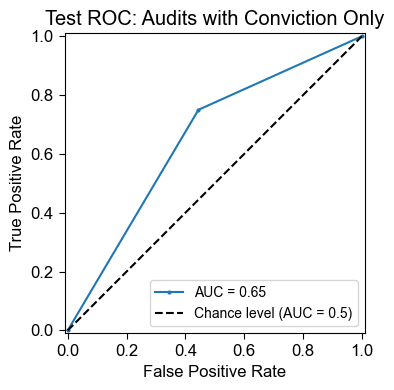

OrderedDict([('nofeats', 0.5231481481481481),
             ('con_only', 0.6527777777777778)])

In [78]:
exp_model_aucs['con_only'] = plot_roc(
    test_df['dohire'], con_test_dohiremeans,
    "Test ROC: Audits with Conviction Only"
)
exp_model_aucs

If all is working as expected, you should observe an increase in AUC score, relative to the baseline model (`nofeats`), result from the new inclusion of `con` as a feature.

And, to reiterate the `kind='response_params'` vs. `kind='response'` distinction one last time, before you move to the last 2 models:

* The code you just wrote, using `kind='response'`, generated (predictive) distributions over the $Y_i$ values **themselves**, the **outcomes** in the model, in contrast to
* The code provided to you immediately beforehand (in the code cell with title `generate-posterior-distributions`) generated distributions over values of the **parameters** $p = \Pr(Y_i = 1)$.

Using the `kind='response'` option therefore plays the same role in Bambi as the `.sample_posterior_predictive()` function plays in base PyMC.

## [Part 2.2] Model With Race Only

Here, so that you can get a feel for carrying out the full Bambi workflow without interruption, the only instruction is to follow the same steps as in Part 2.1, but this time with a model that **only includes `race` as a predictor** (though it should still have an intercept!)

You can use the public tests, after each `response` cell, for guidance on the names of the variables you should be producing in the cell.

### [Question 2.2.1] Write and Fit the Model with Bambi

In [87]:
# @title Q2.2.1-response
race_model = bmb.Model('dohire ~ race', data = train_df, family='bernoulli') # Your code here: replace the None
race_idata = race_model.fit(random_seed=5650) # Your code here: replace the None

Modeling the probability that dohire==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, race]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
# @title Q2.2.1-public-tests
q2_2_1_public_tests = {
    'race_model defined': '✅ Passed!' if 'race_model' in globals() else "🔲 No variable named 'race_model' exists in Python memory",
    'race_idata defined': '✅ Passed!' if 'race_idata' in globals() else "🔲 No variable named 'race_idata' exists in Python memory",
}
q2_2_1_public_tests

### [Question 2.2.2] Extract and Interpret Point Estimates for Coefficients

In [88]:
# @title Q2.2.2-response

# (Step 1) Extract point estimates for coefficients on 'Intercept' and 'con'

# Your code here
intercept_mean = float(race_idata.posterior['Intercept'].mean(dim=['chain','draw']))
intercept_mean
race_mean = float(race_idata.posterior['race'].mean(dim=['chain','draw']))
race_mean

# (Step 2) Use the extracted point estimates to fill in the probability values

pr_dohire_white = expit(intercept_mean + race_mean * 0) # Your code here: replace the None
pr_dohire_black = expit(intercept_mean + race_mean * 1) # Your code here: replace the None

print(pr_dohire_white, pr_dohire_black)

0.23402029415278747 0.07683342605567482


In [ ]:
# @title Q2.2.2-public-tests
q2_2_2_public_tests = {
    'pr_dohire_white filled': '✅ Passed!' if 'pr_dohire_white' is not None else "🔲 Value of 'pr_dohire_white' should not be None",
    'pr_dohire_black filled': '✅ Passed!' if 'pr_dohire_black' is not None else "🔲 Value of 'pr_dohire_black' should not be None",
}
q2_2_2_public_tests

As a sanity check: your "summary" point estimates for `pr_dohire_white` and `pr_dohire_black`, printed out at the end of the previous cell, should be close to the group means computed and displayed by the following code cell:

In [89]:
train_df.groupby('race')['dohire'].mean()

race
0    0.238806
1    0.071429
Name: dohire, dtype: float64

### [Question 2.2.3] Evaluate Predictive Performance on Test Data

In [156]:
# @title Q2.2.3-response

# (Step 1) Call race_model.predict() with appropriate arguments

# Your code here
race_model.predict(race_idata, data=test_df, kind='response')
# (Step 2) Extract the mean of each distribution over dohire, storing the result
# in a variable named race_test_dohiremeans

# Your code here: replace the None
race_test_dohiremeans = race_idata.posterior_predictive['dohire'].mean(dim = ['chain', 'draw']).values

In [ ]:
# @title Q2.2.3-public-tests
q2_2_3_public_tests = {
    'race_test_dohiremeans defined': '✅ Passed!' if 'race_test_dohiremeans' in globals() else "🔲 No variable named 'race_test_dohiremeans' exists in Python memory",
}
q2_1_3_public_tests

And, as before, we provide the final piece of code in the following cell, which displays the ROC curve for your model, stores the corresponding AUC score, and displays our running list of AUC scores for the three models we've estimated thus far:

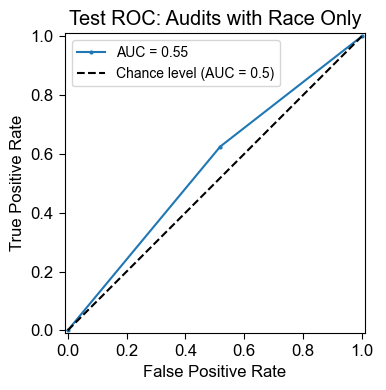

OrderedDict([('nofeats', 0.5231481481481481),
             ('con_only', 0.6527777777777778),
             ('race_only', 0.5532407407407407)])

In [108]:
exp_model_aucs['race_only'] = plot_roc(
    test_df['dohire'], race_test_dohiremeans,
    "Test ROC: Audits with Race Only"
)
exp_model_aucs

## [Part 2.3] Multivariate Logistic Regression Model

Now, the payoff for using Bambi! Whereas the multivariable setting was probably a bit daunting in Part 1, since we had to write out a multivariate Logistic Regression model "from scratch" (and thus had to think about, for example, which specific priors to put on each coefficient), here we can extend the prior two single-variable models in a "natural" way, which should be familiar if you've estimated regressions in R for example.

The main complexity here, relative to the previous two parts, is just that we again want to include an **interaction term** between `race` and `con`, like you did in HW3A. Since Bambi fully imports R's formula syntax, this interaction term can be written in the formula string itself as either **`race * con`** or **`race:con`**. Since the "standard" representation is `race:con`, regardless of which you choose you should see a `race:con` node in the PGM if your interaction term is implemented correctly! In our solutions, the PGM looks as follows:

<center>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/6d575669ede3be71b2a7bc983d2c110c406fa11b/2025-sum-dsan5650/hw3/bambi_multivar.svg" width="60%" />
</center>

### [Question 2.3.1] Write and Fit the Model with Bambi

As you did in Parts 2.1 and 2.2, implement the multivariate logistic regression model (with `race:con` interaction term) in Bambi, storing the model object in a variable named `mvb_model`, then estimate the posterior distribution via `.fit()`, storing the inference data in a variable named `mvb_idata`.

The included line of code at the end displays the PGM for the model, so that you can compare with the image included above.

In [110]:
# @title Q2.3.1-response

# (Step 1) Write the model using R's formula syntax in Bambi
mvb_model = bmb.Model('dohire ~ con + race + race:con', data = train_df, family='bernoulli') # Your code here: replace the None

# (Step 2) Use .fit() to infer posterior distribution
mvb_idata = mvb_model.fit(random_seed=5650) # Your code here: Replace the None

Modeling the probability that dohire==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, con, race, race:con]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
# @title Q2.3.1-public-tests
q2_3_1_public_tests = {
    'mvb_model defined': '✅ Passed!' if 'mvb_model' in globals() else "🔲 No variable named 'mvb_model' exists in Python memory",
    'mvb_idata defined': '✅ Passed!' if 'mvb_idata' in globals() else "🔲 No variable named 'mvb_idata' exists in Python memory",
}
q2_3_1_public_tests

### [Question 2.3.2] Extract and Interpret Point Estimates for Coefficients

Since we now have a multivariable model, with two binary variable `race` and `con`, there are **four** different probability estimates we can derive from our coefficients:

* $\Pr(\texttt{dohire}_i = 1 \mid \texttt{race}_i = \text{White}, \texttt{con}_i = 0)$
* $\Pr(\texttt{dohire}_i = 1 \mid \texttt{race}_i = \text{Black}, \texttt{con}_i = 0)$
* $\Pr(\texttt{dohire}_i = 1 \mid \texttt{race}_i = \text{White}, \texttt{con}_i = 1)$
* $\Pr(\texttt{dohire}_i = 1 \mid \texttt{race}_i = \text{Black}, \texttt{con}_i = 1)$

In the following code cell, use the `mvb_idata` variable you created above to compute these conditional probabilities, then replace the `None` values near the end of the code cell with the appropriate values as indicated.

*(Here we use fancy stuff like `Enum`, `dataclass`, and `namedtuple`, not for the sake of being fancy, but because I've found this combination genuinely useful for creating mini-data structures like this to represent joint probability distributions as the number of possible values starts to become larger than, like, 2 or 3!)*

In [139]:
# @title Q2.3.2-response
# Setup code: Data structures for joint distribution
from enum import Enum
from dataclasses import dataclass

class Race(Enum):
    White = 0
    Black = 1

@dataclass(frozen=True)
class TesterProfile:
    race: Race
    conviction: bool

# (Step 1) derive posterior estimates using mvb_idata, storing the result in
# a variable named mvb_estimates

# Your code here
mvb_estimates = mvb_idata.posterior
# (Step 2) extract posterior point estimates from the mvb_estimates object just
# created

# Your code here
intercept_mean = mvb_estimates.data_vars['Intercept'].mean(dim = ['chain','draw']).values
con_mean = mvb_estimates.data_vars['con'].mean(dim = ['chain','draw']).values
race_mean = mvb_estimates.data_vars['race'].mean(dim = ['chain','draw']).values
race_con_mean = mvb_estimates.data_vars['race:con'].mean(dim = ['chain','draw']).values

# (Step 3) Use the posterior point estimates to compute the four probability
# values (or, if you prefer, you can skip this and just replace the None values
# below directly)
# Your code here
p_dohire_white_noncon = expit(intercept_mean + con_mean * 0 + race_mean * 0 + race_con_mean * 0 * 0)
p_dohire_white_con = expit(intercept_mean + con_mean * 1 + race_mean * 0 + race_con_mean * 0 * 1)
p_dohire_black_noncon = expit(intercept_mean + con_mean * 0 + race_mean * 1 + race_con_mean * 1 * 0)
p_dohire_black_con = expit(intercept_mean + con_mean * 1 + race_mean * 1 + race_con_mean * 1 * 1)

# Once they're computed, replace None values below with estimated probabilities
q2_3_2_response = {
    TesterProfile(race="White", conviction=0): p_dohire_white_noncon,
    TesterProfile(race="White", conviction=1): p_dohire_white_con,
    TesterProfile(race="Black", conviction=0): p_dohire_black_noncon,
    TesterProfile(race="Black", conviction=1): p_dohire_black_con,
}
q2_3_2_response

{TesterProfile(race='White', conviction=0): 0.31448113757676915,
 TesterProfile(race='White', conviction=1): 0.15255150156291816,
 TesterProfile(race='Black', conviction=0): 0.09453549802891793,
 TesterProfile(race='Black', conviction=1): 0.05051183042600331}

In [136]:
# @title Q2.3.2-public-tests
def all_none(response_dict):
    response_vals = list(response_dict.values())
    return all([v is None for v in response_vals])
q2_3_2_public_tests = {
    'q2_3_2_response defined': '✅ Passed!' if 'q2_3_2_response' in globals() else "🔲 No variable named 'q2_3_2_response' exists in Python memory",
    'No None values': '✅ Passed!' if ('q2_3_2_response' in globals()) and (not all_none(q2_3_2_response)) else "🔲 One or more of the values in 'q2_3_2_response' is None",
}
q2_3_2_public_tests

{'q2_3_2_response defined': '✅ Passed!', 'No None values': '✅ Passed!'}

### [Question 2.3.3] Evaluate Predictive Performance on Test Data

In [ ]:
# @title Q2.3.3-response

# (Step 1) Use .predict(), with appropriate arguments, to generate the posterior
# predictive distribution (which will be stored in mvb_idata automatically)

# Your code here
mvb_model.predict(mvb_idata, data=test_df, kind='response')
az.summary(mvb_idata)
# (Step 2) Derive the mean dohire values from `mvb_idata.posterior_predictive`,
# storing the results in a variable named mvb_test_dohiremeans
mvb_idata.posterior_predictive
mvb_test_dohiremeans = None # Your code here: replace the None

mvb_test_dohiremeans

In [ ]:
# @title Q2.3.3-public-tests
q2_3_3_public_tests = {
    'mvb_test_dohiremeans defined': '✅ Passed!' if 'mvb_test_dohiremeans' in globals() else "🔲 No variable named 'mvb_test_dohiremeans' exists in Python memory",
}
q2_3_3_public_tests

And we can now display the ROC curve and store the AUC score for our final behavior model!

In [ ]:
exp_model_aucs['multivar'] = plot_roc(
    test_df['dohire'], mvb_test_dohiremeans,
    "Test ROC: Multivariate Model"
)
exp_model_aucs

Here you can ponder on whether/why the multivariate model may have failed to perform best out of all models in Part 2 (though, it will likely be close between `multivar` and `con_only`, and, in a full-on modeling scenario we'd use **regularizing priors** to constrain the multivariate model's ability to overfit, and it would then likely come out on top unambiguously!)

# [Part 3] Modeling Attitudes *and* Behaviors *and* Their Connection(s)!

**Overview: One Model, One Multiple-Choice Question**

This part will be almost entirely **reading** and **running pre-written code** because... well, I was trying to come up with a way to make this attitude-behavior cross-prediction model as interactive and step-by-step as Parts 1 and 2, but... in the end I'd rather that you focus on the concepts! Meaning, focus on how you can model **indidvidual "pieces" of your problem** like you did in the previous two parts, and then **fuse** them together to model the dynamics of how the two pieces interrelate, going back and tweaking the individual pieces as needed.

This turns out to be one of the three or four most game-changing aspects of the **modular** PGM approach (along with the missing-data-imputation-for-free and the distributions-rather-than-point-estimates features I've ranted about thus far): to see it in action, it's so so worth reading [Lee and Wagenmakers (2013), *Bayesian Cognitive Modeling*](https://www.dropbox.com/scl/fi/7flgs68gpesokk3xpn2dw/Bayesian-cognitive-modeling-_-a-practical-course.pdf?rlkey=504q33aqpeldz7go0x4kicjqe&st=o3548lkc&dl=1), from cover-to-cover, since it builds step-by-step from the simplest possible PGMs to PGMs used in modern cognitive science research!

So, your task is to read the following, implement one final model in Part 3.1 (the only part! That I walk you through as quickly as possible!), and then answer one last **multiple-choice question** at the end of that part where you just **promise to... at least scroll through** the [**"HW3 Grand Finale" writeup**](https://jjacobs.me/dsan5650/writeups/birthday-instrument/) on the website.

The reason it's called the "HW3 Grand Finale" is because, it takes the model from Part 3.1 below and extends it into a full-on **joint-inferential** model of attitudes and behaviors. Meaning, in other words, a model **optimized for prediction of behaviors from attitudes, and vice-versa**, by just "turning the crank" of Bayes' rule as carried out by PyMC 🤓 Onwards and upwards...

## Context for Part 3: Attitude-Behavior Consistency

The lack of consistency between your results from Part 1 and from Part 2 hopefully helps point towards why social psychologists have been studying [**Attitude-Behavior Consistency (ABC)**](https://en.wikipedia.org/wiki/Attitude-behavior_consistency) for many decades now! C. Wright Mills, for example (who is apparently the [fourth-most-cited sociologist of all time](https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=label:sociology)), posited back in 1940 that

> *Perhaps the central methodological problem of the social sciences [comes from the] disparity between lingual and social-motor types of behavior.*
>
> &mdash;[Mills (1940)](https://www.jstor.org/stable/2769572?seq=1)

Thankfully for us, as **computational social scientists**, we have the modeling language of **Probabilistic Graphical Models**, within which we can explicitly differentiate between **latent** and **observable** variables<sup>[1]</sup>. The logic underlying the model in this section, then, is as follows:

* We can model **"Attitudes" $A$** as latent variables which **do not determine observed behavior on their own!**
* Instead, they lead to **different behavior in different Contexts $C$**.
* We'll thus define two contexts, $\textsf{Saying}$ and $\textsf{Doing}$, as two possible values for $C$.
* The telephone survey you modeled in **Part 1** will represent the **Value-Reporting** context $\textsf{Saying}$, while
* The experimental audit you modeled in **Part 2** will represent the **Decision-Making** context $\textsf{Doing}$

The point, however, is to approach this problem with the same kind of testing-rather-than-assuming framework that the **multilevel models** you looked at in HW2 allow us to take. The analogy between multilevel models and the model in this part (and thus between HW2 and HW3) is summarized in the following table:

| | Possible Multilevel Models | Possible Attitude-Behavior Models |
| - | - | - |
| **No-Pooling** | **The assumption**: Within Africa, learning the views of someone in country $x$ tells us nothing about the views of someone in country $y$<br><br>**Methodological result**: We just fit $N$ different regressions for the $N$ countries in Africa<br><br>**The issue**: Think of e.g. Sudan vs. South Sudan---some people in South Sudan went to sleep on [8 July 2011](https://www.bbc.com/news/world-africa-14069082) as Sudanese citizens and woke up the next day as South Sudanese citizens. So, we can probably infer at least *something* about South Sudanese attitudes by e.g. learning the views of Sudanese citizens near the southern border! | **The assumption**: Learning someone's views from a survey gives us no useful information about their behavior<br><br>**Methodological result**: We have survey data from a set of people $S$, alongside experimental results from that same set of people, but no way to connect them (which would massively increase the statistical power of our inferences about $S$)<br><br>**The issue**: People, at least under Festinger's theory of [cognitive dissonance](https://www.jstor.org/stable/24936719), sometimes go to great pains to bring their *behavior* in line with their *values*. So, if this theory holds even a little bit, we can usually at least learn *something* about people's behavior from their stated beliefs/attitudes (allowing us to predict it better than random guessing!) |
| **Full-Pooling** | **The assumption**: The difference between person $i$'s country and person $j$'s country is not salient to understanding their views<br><br>**Methodological result**: We estimate one big regression, throwing away the `country` variable<br><br>**The issue**: People within a country often have shared "norms", which give rise to correlations across their individual values (something we could actually try to measure with the data!) | **The assumption**: The views professed by someone in a survey gives us all the information we need about their behavioral proclivities<br><br>**Methodological result**: We don't need to conduct an experiment at all!<br><br>**The issue**: People often behave in a way that conflicts with their professed values, so we may be "assuming away" an important aspect of whatever social phenomenon we're trying to study (hiring decisions, voting, etc.) |
| **Adaptive Pooling** | **The assumption**: We can explicitly **incorporate** the degree of similarity/discrepancy between views of people in country $x$ and country $y$ as a part of our model<br><br>**Methodological result**: We can then use this estimated degree of similarity/discrepancy to e.g. develop better estimates for countries with limited data availability | **The assumption**: We can explicitly **incorporate** the degree of similarity/discrepancy between professed behavior in hypothetical scenarios and observed behavior in real-world scenarios<br><br>**Methodological result**: We can then use this estimated degree of similarity/discrepancy to e.g. develop better estimates for people's behavior given only information on their professed views, and vice-versa! |

Hopefully those details drive home the point made at the end of the same article quoted earlier:

> While survey and interview methods may offer a window into "attitudinal frames," it is important that they
also demonstrate, rather than assume, the impact of these frames upon activities in the world
>
> &mdash;[Jerolmack and Khan (2014)](https://doi.org/10.1177/0049124114523396)

If our model "succeeds", then, we should be able to use it as essentially a "bullshit-calibrator": a way to take people's professed beliefs and derive useful estimates of their behavior, and vice-versa... Let's get to it!

---

<small>

1. Sadly, I only was able to find [\[two\]](https://www.sciencedirect.com/science/article/pii/S0010027709001607) [\[articles\]](https://www.research.ed.ac.uk/en/publications/predicting-actions-using-an-adaptive-probabilistic-model-of-human) which mention probabilistic models as a possible approach to studying Attitude-Behavior Consistency, so... I made this footnote to link them and encourage yall to pursue these questions! 😜

</small>

## Loading and Exploring the Dataset

In [226]:
%run jupyter_fixes.ipynb
import pandas as pd
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import seaborn as sns
import patchworklib as pw

import pymc as pm
import arviz as az

**Firm-Level Data**

The following code cell loads the first, **firm-level** dataset used in this part, `pager_matched_firms.csv`. The firms in each row are uniquely identified by `firm_id`, and for each firm we have the following information:

* `region_str`: A string variable which is `"Urban"` for firms within the city of Milwaukee itself, and `"Suburban"` for firms located outside of the city (but within the [Milwaukee metropolitan area](https://en.wikipedia.org/wiki/Milwaukee_metropolitan_area))
* `region`: The same information as `region_str`, but where **Urban** firms have value `0` and **Suburban** firms have value `1` (for easier use with our ML libraries)
* `industry`: A categorical string variable, not used here but, it came with the dataset and you can think about how the analysis could be expanded to incorporate this info!

In [242]:
firm_df = pd.read_csv("pager_matched_firms.csv")
firm_df.head()

,firm_id,region_str,industry,region
0,0,Urban,Retail Trade,0
1,1,Urban,Retail Trade,0
2,2,Suburban,Retail Trade,1
3,3,Urban,Retail Trade,0
4,4,Urban,Retail Trade,0


**Auditor-Level Data**

Then, the following code cell loads a new, expanded-via-imputation version of the **auditor** data from Part 2<sup>[1]</sup>. It has the same variables, but a greater number of audits per firm, thus introducing **within-firm variation** for given (race, conviction-status) values, ensuring that the model in this section is **identifiable** despite its greater number of parameters.

---

<small>

1.  *Why is there a new, expanded version? What was wrong with the Part 2 dataset?* The dataset you just used had **four audits per firm**: one for each possible (race, conviction-status) pair. This made things more manageable, for wrapping-mind-around purposes, but also means that we had the minimum possible **within-firm variation** for an estimable model. To make it possible to estimate the **additional** parameters in this section's model, therefore, I drew additional samples from the overall joint distribution of variables from the original dataset (using PyMC's `pm.sample_posterior_predictive()` function!) This ensures that the **summary statistics** (and findings of their study) remain approximately the same as before, but that we now have **40 (simulated) audits per firm** (ten per possible race x conviction-status pair)) rather than just 4.

</small>

In [243]:
audit_df = pd.read_csv("pager_matched_auditors.csv")
audit_df.head()

,auditor_id,firm_id,con,race,race_str,dohire
0,0,0,0,0,White,0
1,1,0,1,0,White,1
2,2,0,0,1,Black,0
3,3,0,1,1,Black,0
4,4,1,0,0,White,1


## Summary Statistics and Visualization

By computing the same summary statistics we computed in Part 2, we can see how the expansion-via-imputation has preserved many substantive aspects of the dataset (for example, the high-to-low ordering of groups in terms of `dohire` rates). Because of how Bayesian imputation works, though, it *has* brought the group rates closer together -- for the same reason that the estimates for the low-data-availability "Zudan" country from HW2 were "shrunk" down to be closer to the overall (pooled) mean!

In [244]:
audit_rate_df = audit_df.groupby(['race_str','con'])['dohire'].mean().to_frame().reset_index()
audit_rate_df.rename(columns={'dohire': 'callback_rate'}, inplace=True)
audit_rate_df

,race_str,con,callback_rate
0,Black,0,0.302326
1,Black,1,0.248837
2,White,0,0.400000
3,White,1,0.330233


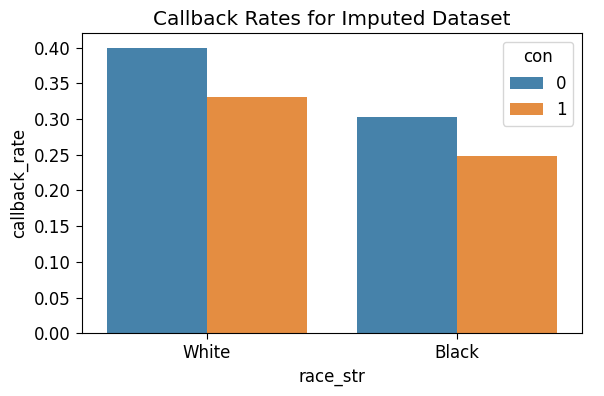

In [245]:
ax = pw.Brick(figsize=(5, 3));
sns.barplot(
    x="race_str", y='callback_rate', hue='con', data=audit_rate_df,
    alpha=0.9, order=['White','Black'], ax=ax
);
ax.set_title("Callback Rates for Imputed Dataset")
ax.savefig()

This "smoothing out" of inter-group differences is, sadly, the price that must be paid if we want a dataset with **greater** within-firm variation but **approximately-similar** group effects, unless we're willing to bring additional assumptions to this procedure (it turns out to be very similar to the ["differential privacy" approach](https://www.census.gov/programs-surveys/decennial-census/decade/2020/planning-management/process/disclosure-avoidance/differential-privacy.html) utilized by the US Census starting in 2020, and if you took DSAN5450 with me you may also be able to see the connection between the two!).

With all that said, let's build our model **connecting** attitudes and behaviors! Your job is just to answer the multiple-choice questions at the end of each sub-part.

## [Part 3.1] *(The Only Sub-Part!)* A Multilevel Model of Attitudes

In [256]:
%run jupyter_fixes.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patchworklib as pw
import pymc as pm
import arviz as az
from scipy.special import expit

First, in addition to re-including the imports above (so that you can work on this part independently of Part 2), we'll also re-load the **survey** data just in case, since it's the main data we'll be using to model **attitudes** at both the **region** and **firm** level:

In [249]:
survey_df = pd.read_csv("pager_matched_surveys.csv")
survey_df.head()

,survey_id,firm_id,con,race,race_str,sayhire
0,0,0,0,0,White,1
1,1,0,1,0,White,0
2,2,0,0,1,Black,1
3,3,0,1,1,Black,0
4,4,1,0,0,White,1


### [Question 3.1.1] Write and Fit Model with PyMC

Your job now is just to implement 1/3 of the full cross-predictive model! (The next 1/3 would be a multilevel model of **behaviors**, and then the final 1/3 would be the **latent ABC variable** linking these first two models)

Writing it out in the step-by-step, generative form that you saw all the way back in HW1, the key **Parameter RVs** of the model (as in, this does not yet account for how the observed data gets "plugged in", which will be covered by the PGM image below this table):

| | | | | |
| - | - | - | - | - |
| 1. | `ascore_city` | $\sim$ | $\mathcal{N}(0, 1.5)$ | Generate an "attitude score" -- called that because it plays a role in determining $\Pr(\texttt{sayhire})$, but is a **log-odds** score rather than a probability (so it can range from $-\infty$ to $\infty$, and we can put this nice Normal distribution prior on it, then convert it into a probability further down the line) |
| 2. | `ascore_region` | $\sim$ | $(\mathcal{N}(0, 1), \mathcal{N}(0, 1))$ | I know this notation is confusing, but it is written this way to indicate that you should implement this variable as a 2-element **vector** of `pm.Normal()` RVs.<br><br>This will allows you to straightforwardly use a given firm's **`region_obs` value** as an **index** into this vector, in Step 3. This also means that you no don't need to use `pm.math.switch()` anywhere in this model! (Though you won't be penalized for using that approach instead of this indexing approach) |
| 3. | `ascore_firm` | $\sim$ | $\mathcal{N}(\texttt{ascore\_region[region\_obs]}, 1)$ | This is the "final" attitude score, the attitude score at the **firm** level, which is the lowest level in the multilevel model with an "attitude score" property |
| 4. | `p_sayhire` | $\leftarrow$ | $\text{logit}^{-1}(\texttt{ascore\_firm})$ | This is the payoff from using attitude **scores** (in log-odds units) in Steps 1-3 rather than attitude **probabilities**: the **regional** attitude scores vary around the city mean via the "natural" choice of the Normal distribution, then the **firm** attitude scores vary around the mean of their regions again via the "natural" Normal distribution, until finally at this point we **convert** from log-odds scores into human-interpretable **probabilities of saying "likely hire"** in response to the Chad vignette. |
| 5. | `sayhire` | $\sim$ | $\text{Bern}(\texttt{p\_sayhire[survey\_firm\_ids]})$ | This is the "outcome" variable, in the same general form you've implemented a bunch of times now (so, for example, this is where you should include the `observed=` argument to `pm.Bernoulli()`).<br><br>The only slightly-fancier thing now is that, we need to generate **multiple** Bernoulli outcomes for **each** firm (one Bernoulli outcome for each **auditor** who was assigned to a given firm). That's your final challenge: to figure out how to use the `dims=` argument to handle this "mismatch" between the number of **firms** and the number of **auditors** in this Part 3 dataset. |

Steps 1-4 thus represent the four main **parameters** of the model, and Step 5 represents the **outcome** (which is why this "final step" variable is often referred to as the **likelihood link**: it serves as a kind of "interface" between the observed data and the hypothesized model parameters when the MCMC algorithm is... "churning" back and forth between the two, with the aim of maximizing the model's log-likelihood function).

When it's all put together, the model should look something like the following, which also makes explicit where exactly the **data** nodes enter the model:

<center>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/132f79397ffb46cc21ef9ceb15eb520d2600a03e/2025-sum-dsan5650/hw3/multilevel_attitude.svg" width="40%" />
</center>

In [ ]:
# @title Q3.1.1-response
mla_coords = {
    'region': ['Urban','Suburban'],
    'audit_id': audit_df.index.values,
    'survey_id': survey_df.index.values,
    'firm_id': firm_df.index.values,
}
survey_firm_ids = survey_df['firm_id'].values

# Your code here: Implement the model, as described above, giving it the name
# mla_model (for MultiLevel Attitude model)



# Once you've implemented the model, uncomment the following line to display
# it in PGM form -- then you can compare it with the image included above, as
# a sanity check!

# pm.model_to_graphviz(mla_model)

In [ ]:
# @title Q3.1.1-public-tests
q3_1_1_public_tests = {
    'mla_model defined': '✅ Passed!' if 'mla_model' in globals() else "🔲 No variable named 'mla_model' exists in Python memory",
}
q3_1_1_public_tests

### [Question 3.1.2] Extract Point Estimates for `ascore_region`

Now that your model is ready to go, in the following code cell, use the `pm.sample()` function to estimate the posterior distributions for the parameters in `mla_model`.

Though `pm.sample()` estimates this distribution for **all** parameters, here we'll focus in specifically on **`ascore_region`**. The idea is that, even with just this "piece" of the full cross-predictive model, we can **compare the posterior distributions** of **`ascore_region[Urban]`** and **`ascore_region[Suburban]`** to get a sense for **which subset of firms in the Milwaukee area are more likely to respond positively to applicants, overall!** This was the original purpose of this whole part of the assignment: a Bayesian model allowing yall to "input" characteristics and get back predicted $\Pr(`sayhire` = 1)$ values **and** predicted $\Pr(`dohire` = 1)$ values. As it stands, the writeup mentioned above is now where that magic model lives!

As a final detail on the included code: Since the `az.summary()` tables can start to look cluttered once you add more and more variables to your model, here the included code uses its optional `var_names=` argument to ensure that the table only summarizes the posterior distributions for `ascore_region`.

The following table was copied directly from our solutions (with the cell values removed), so you can see exactly the form that the results take on if your model implementation uses `region_obs` as an index into the 2-element vector RV `ascore_region`.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align:right">
      <th></th>
      <th>mean</th>
      <th>sd</th>
      <th>hdi_3%</th>
      <th>hdi_97%</th>
      <th>mcse_mean</th>
      <th>mcse_sd</th>
      <th>ess_bulk</th>
      <th>ess_tail</th>
      <th>r_hat</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ascore_region[Urban]</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>ascore_region[Suburban]</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
  </tbody>
</table>

In [261]:
# @title Q3.1.2-response

# Use pm.sample(random_seed=5650) to estimate the posterior
# distributions of the parameters in mla_model, storing the result in a variable
# named mla_idata

# Your code here

# If implemented correctly (and using region_obs as the index for ascore_region),
# uncommenting the following line should generate a table that looks like the
# above skeleton table, but with the cell values filled in!

# az.summary(mla_idata, var_names=['ascore_region'])

In [ ]:
# @title Q3.1.2-public_tests
q3_1_2_public_tests = {
    'mla_idata defined': '✅ Passed!' if 'mla_idata' in globals() else "🔲 No variable named 'mla_idata' exists in Python memory",
}
q3_1_2_public_tests

### [Question 3.1.3] Interpret `ascore_region` Point Estimates

This is the final coding question on HW3 (besides the multiple choice and pinky promise questions below)!

There is one step left, which you saw in Parts 1 and 2 as well: though we can already see from the `az.summary()` table above which of the regions has a **higher** $\Pr(\texttt{sayhire} = 1)$ value, we don't yet know **what this value is** for the two regions!

So, in the following code cell, use the `expit()` function (that was sneakily imported at the beginning of Part 3) to compute the two **probabilities**

* $\Pr(\texttt{sayhire}_j = 1 \mid \text{Region}_j = \text{Urban})$ and
* $\Pr(\texttt{sayhire}_j = 1 \mid \text{Region}_j = \text{Suburban})$,

where $j$ indexes **firms** in this case, then store these values in `pr_sayhire_urban` and `pr_sayhire_suburban`, respectively.

In [ ]:
# @title Q3.1.3-response

# (Step 1) Extract point estimates for ascore_region from mla_idata.posterior

# Your code here

# (Step 2) Use these point estimates, along with expit(), to derive the
# probability point estimates mentioned above

pr_sayhire_urban = None # Your code here: replace the None
pr_sayhire_suburban = None # Your code here: replace the None

print(pr_sayhire_urban, pr_sayhire_suburban)

In [281]:
# @title Q3.1.3-public-tests
q3_1_3_public_tests = {
    'pr_sayhire_urban defined': '✅ Passed!' if 'pr_sayhire_urban' in globals() else "🔲 No variable named 'pr_sayhire_urban' exists in Python memory",
    'pr_sayhire_suburban defined': '✅ Passed!' if 'pr_sayhire_suburban' in globals() else "🔲 No variable named 'pr_sayhire_suburban' exists in Python memory",
}
q3_1_3_public_tests

{'pr_sayhire_urban defined': '✅ Passed!',
 'pr_sayhire_suburban defined': '✅ Passed!'}

### [Question 3.1.4] Log-Odds $\rightarrow$ Interpretable Probabilities

Answer this question based on what you found in the previous two sub-parts.

Say your name is Chad, and you're searching for a job in the Milwaukee metro area. You only have the pieces of information derived above at your disposal, and you're about to fall asleep, so you only have time to perform one job search on [milwaukeejobs.com](https://www.milwaukeejobs.com/). Consider the following two searches, where (as can be seen on [this page](https://www.milwaukeejobs.com/jobs/location) "Milwaukee" on this site refers to jobs within the "official" urban city limits of Milwaukee proper:

* (a) [Jobs with Location = "Milwaukee"](https://www.milwaukeejobs.com/j/l-Milwaukee,-WI-jobs-l31.html)
* (b) [Jobs with Location $\neq$ "Milwaukee"](https://www.milwaukeejobs.com/jobs/location)

Which search would be **more likely** to lead you to an employer who expresses a positive attitude towards hiring? ***(Choose one option by replacing the `""` with the letter for your answer)***

In [267]:
# @title Q3.1.4-response
q3_1_4_reponse = "" # Replace with "a" for option (a), "b" for option (b)

In [268]:
# @title Q3.1.4-public-tests
q3_1_4_public_tests = {
    'q3_1_4_response defined': '✅ Passed!' if 'q3_1_4_response' in globals() else "🔲 No variable named 'q3_1_4_response' exists in Python memory",
}
q3_1_4_public_tests

{'q3_1_4_response defined': "🔲 No variable named 'q3_1_4_response' exists in Python memory"}

### [Question 3.1.5] The Pinky-Promise

Do you pinky-promise to at least scroll through the [**"HW3 Grand Finale" writeup**](https://jjacobs.me/dsan5650/writeups/abc-cross-prediction/), extending this model to full cross-prediction of attitudes and behaviors?

* (a) Yes
* (b) Double Yes
* (c) Only lowercase yes

In [282]:
# @title Q3.1.5-response
q3_1_5_response = "" # Replace with "a" for choice (a), "b" for choice (b), "c" for choice (c)

In [283]:
# @title Q3.1.5-public-tests
q3_1_5_public_tests = {
    'q3_1_5_response defined': '✅ Passed!' if 'q3_1_5_response' in globals() else "🔲 No variable named 'q3_1_5_response' exists in Python memory",
}
q3_1_5_public_tests

{'q3_1_5_response defined': '✅ Passed!'}

Thank you for your patience! And, if it helps, here is the PGM for the full model in the writeup, that I have benevolently spared you from having to write! 😇👼🤗 Though it looks scary at first, you can think about how it could be "built up" from the piece of it that you just created in Part 3.1!

<center>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/2d66bec8877046fbaac4350bd8295c4c334a8a69/2025-sum-dsan5650/hw3/multilevel_abc.svg" width="60%" />
</center>